Adapted from [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
# Bunch of useful libraries + wngrad
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
import torch
from sklearn.datasets import load_svmlight_file
import random
import helpers
from wngrad import WNGrad
import torchvision
import copy
%matplotlib inline

In [2]:
# import tensorflow.keras.datasets.mnist as mnist
# (train_input, train_target), (test_input, test_target) = mnist.load_data()

# train_input = torch.from_numpy(train_input.astype('float64'))
# train_input = train_input.data.view(-1, 1, 28, 28).float()
# train_target = torch.from_numpy(train_target.astype('float64'))
# test_input = torch.from_numpy(test_input.astype('float64'))
# test_input = test_input.data.view(-1, 1, 28, 28).float()
# test_target = torch.from_numpy(test_target.astype('float64'))

# batch_size = 10

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_1batch = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


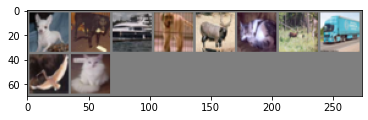

  dog   dog  ship   dog  deer   cat  deer truck  bird   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train_SGD(optimizer, net, epochs):
    history = defaultdict(list)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            net.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if 'SGD' in str(optimizer):
                optimizer.step()
            elif 'WNGrad' in str(optimizer):
                
                # Store original parameters, and flatten params and grad
                if epoch == 0 and i == 0:
                    b_candidates = []
                    orig_param_list = []
                    grad_flat = torch.empty((0,))
                    param_flat = torch.empty((0,))
                    layers = []
                    for name, param in net.named_parameters():
                        orig_param_list.append(param)
                        grad_flat = torch.cat((grad_flat, param.grad.flatten()))
                        param_flat = torch.cat((param_flat, param.flatten()))
                        layers.append(name.split('.')[0])

                    for i in np.arange(-5, 0, 0.1):
                        for i_layer, layer in enumerate(layers):
                            if i_layer % 2 == 0: # Weight
                                getattr(net, layers[i_layer].split('.')[0]).weight = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))
                            else:
                                getattr(net, layers[i_layer].split('.')[0]).bias = torch.nn.Parameter(
                                    orig_param_list[i_layer] + torch.empty_like(orig_param_list[i_layer]).normal_(0, 10**i))



                        # Get gradient
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
#                         print(getattr(net, layers[i_layer].split('.')[0]).bias.grad)
                        loss.backward()

                        # Retreive gradient
                        grad_flat_temp = torch.empty((0,))
                        param_flat_temp = torch.empty((0,))
                        for name, param in net.named_parameters():
                            grad_flat_temp = torch.cat((grad_flat_temp, param.grad.flatten()))
                            param_flat_temp = torch.cat((param_flat_temp, param.flatten()))
                        
#                         print(grad_flat_temp.mean(), grad_flat.mean(), param_flat_temp.mean(), param_flat.mean(),)
                        b_candidates.append((grad_flat_temp - grad_flat).norm(2)/(param_flat_temp - param_flat).norm(2))

                        # Once initialization search is over...
                    
                    # Put originals back in place
                    for i_layer, layer in enumerate(layers):
                        if i_layer % 2 == 0: # Weight
                            getattr(net, layers[i_layer].split('.')[0]).weight = orig_param_list[i_layer]
                        else:
                            getattr(net, layers[i_layer].split('.')[0]).bias = orig_param_list[i_layer]
                    
                    # And choose a b
#                     print(b_candidates)
                    b = max(b_candidates)
#                     b = 50
                    print('Initial_b: ', b, 'Max candidates: ', sorted(b_candidates)[-2])
                    optimizer.b = b
#                     raise Exception()
                elif i % 500 == 499:
                    print('Current b:', optimizer.b)
                def closure():
                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    return loss
                optimizer.step(closure)

            # print statistics
            running_loss += loss.item()
#             if i % 10 == 9:    # Store every 10 mini-batches
#                 history["iter"].append(i*(epoch+1))
#                 history["loss"].append(running_loss)
# #                 print(f'loss = {running_loss}')
# #                 print('[%d, %5d] loss: %.3f' %
# #                       (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
            if i % 500 == 499:    # print every 2000 mini-batches
                net.eval()
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5000))
                history["iter"].append(i+len(trainloader)*epoch+1)
                history["train loss"].append(running_loss)
                running_loss = 0.0
                total = 0
                correct = 0
                with torch.no_grad():
                    test_loss = 0
                    for data in testloader:
                        images, labels = data
                        # calculate outputs by running images through the network
                        outputs = net(images)
                        test_loss += criterion(outputs, labels)
                        
                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                history["test accuracy"].append(100*correct/total)
                print(100*correct/total, '%')
                history["test loss"].append(test_loss)
#                 print('Accuracy of the network on the 10000 test images: %d %%' % (
#                     100 * correct / total))
    return history

In [12]:
# Define Criterion
epochs = 10
criterion = torch.nn.CrossEntropyLoss()
net_SGD = Net()
optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
history = train_SGD(optimizer_SGD, net_SGD, epochs)
# Redo with WNGrad-mod
net_WNGrad = Net()
optimizer_WNGrad_mod = WNGrad(net_WNGrad.parameters())
history_WNGrad_mod = train_SGD(optimizer_WNGrad_mod, net_WNGrad, epochs)
# Redo with WNGrad original
net_WNGrad = Net()
optimizer_WNGrad = WNGrad(net_WNGrad.parameters())
history_WNGrad = train_SGD(optimizer_WNGrad, net_WNGrad, epochs)

[1,   500] loss: 0.230
13.68 %
[1,  1000] loss: 0.230
20.97 %
[1,  1500] loss: 0.228
16.17 %
[1,  2000] loss: 0.213
27.03 %
[1,  2500] loss: 0.196
31.34 %
[1,  3000] loss: 0.187
34.09 %
[1,  3500] loss: 0.178
37.92 %
[1,  4000] loss: 0.170
38.47 %
[1,  4500] loss: 0.168
38.05 %
[1,  5000] loss: 0.163
42.06 %
[2,   500] loss: 0.161
43.42 %
[2,  1000] loss: 0.152
45.14 %
[2,  1500] loss: 0.152
45.42 %
[2,  2000] loss: 0.149
45.81 %
[2,  2500] loss: 0.146
46.52 %
[2,  3000] loss: 0.147
46.38 %
[2,  3500] loss: 0.142
47.82 %
[2,  4000] loss: 0.143
48.93 %
[2,  4500] loss: 0.140
49.11 %
[2,  5000] loss: 0.142
51.28 %
[3,   500] loss: 0.135
49.81 %
[3,  1000] loss: 0.133
51.68 %
[3,  1500] loss: 0.134
51.89 %
[3,  2000] loss: 0.133
52.73 %
[3,  2500] loss: 0.131
53.32 %
[3,  3000] loss: 0.130
50.1 %
[3,  3500] loss: 0.130
54.38 %
[3,  4000] loss: 0.129
54.75 %
[3,  4500] loss: 0.125
52.59 %
[3,  5000] loss: 0.127
54.39 %
[4,   500] loss: 0.124
54.4 %
[4,  1000] loss: 0.120
54.74 %
[4,  1500]

In [14]:
net_WNGrad = Net()
optimizer_WNGrad_bsq = WNGrad(net_WNGrad.parameters(), b_sq = True)
history_WNGrad_bsq = train_SGD(optimizer_WNGrad_bsq, net_WNGrad, epochs)

Initial_b:  tensor(69.9417, grad_fn=<DivBackward0>) Max candidates:  tensor(57.8722, grad_fn=<DivBackward0>)
Current b: tensor(71.4505)
[1,   500] loss: 1.622
16.87 %
Current b: tensor(92.4500)
[1,  1000] loss: 0.214
26.05 %
Current b: tensor(133.8961)
[1,  1500] loss: 0.196
29.33 %
Current b: tensor(170.4706)
[1,  2000] loss: 0.190
32.75 %
Current b: tensor(207.9807)
[1,  2500] loss: 0.185
34.72 %
Current b: tensor(245.8147)
[1,  3000] loss: 0.178
35.04 %
Current b: tensor(284.0831)
[1,  3500] loss: 0.172
37.61 %
Current b: tensor(322.2308)
[1,  4000] loss: 0.172
39.13 %
Current b: tensor(360.9012)
[1,  4500] loss: 0.166
40.01 %
Current b: tensor(398.8606)
[1,  5000] loss: 0.166
38.51 %
Current b: tensor(434.4100)
[2,   500] loss: 0.162
40.65 %
Current b: tensor(470.2364)
[2,  1000] loss: 0.162
40.99 %
Current b: tensor(505.0140)
[2,  1500] loss: 0.159
41.58 %
Current b: tensor(537.5580)
[2,  2000] loss: 0.157
41.18 %
Current b: tensor(570.6817)
[2,  2500] loss: 0.157
41.78 %
Current 

In [23]:
# Redo with Adagrad
net_Adagrad = Net()
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters())
history_Adagrad = train_SGD(optimizer_Adagrad, net_Adam, epochs)
# Redo with Adam
net_Adam = Net()
optimizer_Adam = torch.optim.Adam(net_Adam.parameters())
history_Adam = train_SGD(optimizer_Adam, net_Adam, epochs)

[1,   500] loss: 0.231
10.0 %
[1,  1000] loss: 0.230
10.0 %
[1,  1500] loss: 0.230
10.0 %
[1,  2000] loss: 0.230
10.0 %
[1,  2500] loss: 0.230
10.0 %
[1,  3000] loss: 0.230
10.0 %
[1,  3500] loss: 0.230
10.0 %
[1,  4000] loss: 0.230
10.0 %
[1,  4500] loss: 0.230
10.0 %
[1,  5000] loss: 0.231
10.0 %
[2,   500] loss: 0.231
10.0 %
[2,  1000] loss: 0.230
10.0 %
[2,  1500] loss: 0.230
10.0 %
[2,  2000] loss: 0.231
10.0 %
[2,  2500] loss: 0.231
10.0 %
[2,  3000] loss: 0.231
10.0 %
[2,  3500] loss: 0.230
10.0 %
[2,  4000] loss: 0.230
10.0 %
[2,  4500] loss: 0.231
10.0 %
[2,  5000] loss: 0.230
10.0 %
[3,   500] loss: 0.230
10.0 %
[3,  1000] loss: 0.230
10.0 %
[3,  1500] loss: 0.230
10.0 %
[3,  2000] loss: 0.230
10.0 %
[3,  2500] loss: 0.230
10.0 %
[3,  3000] loss: 0.231
10.0 %
[3,  3500] loss: 0.231
10.0 %
[3,  4000] loss: 0.230
10.0 %
[3,  4500] loss: 0.230
10.0 %
[3,  5000] loss: 0.230
10.0 %
[4,   500] loss: 0.231
10.0 %
[4,  1000] loss: 0.231
10.0 %
[4,  1500] loss: 0.230
10.0 %
[4,  2000]

## Test

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net_WNGrad(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship


In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_WNGrad(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Accuracy of the network trained with WNGrad on the 10000 test images: {acc}')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_SGD(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Accuracy of the network trained with SGD on the 10000 test images: {acc}')

Accuracy of the network trained with WNGrad on the 10000 test images: 45.71
Accuracy of the network trained with SGD on the 10000 test images: 51.33


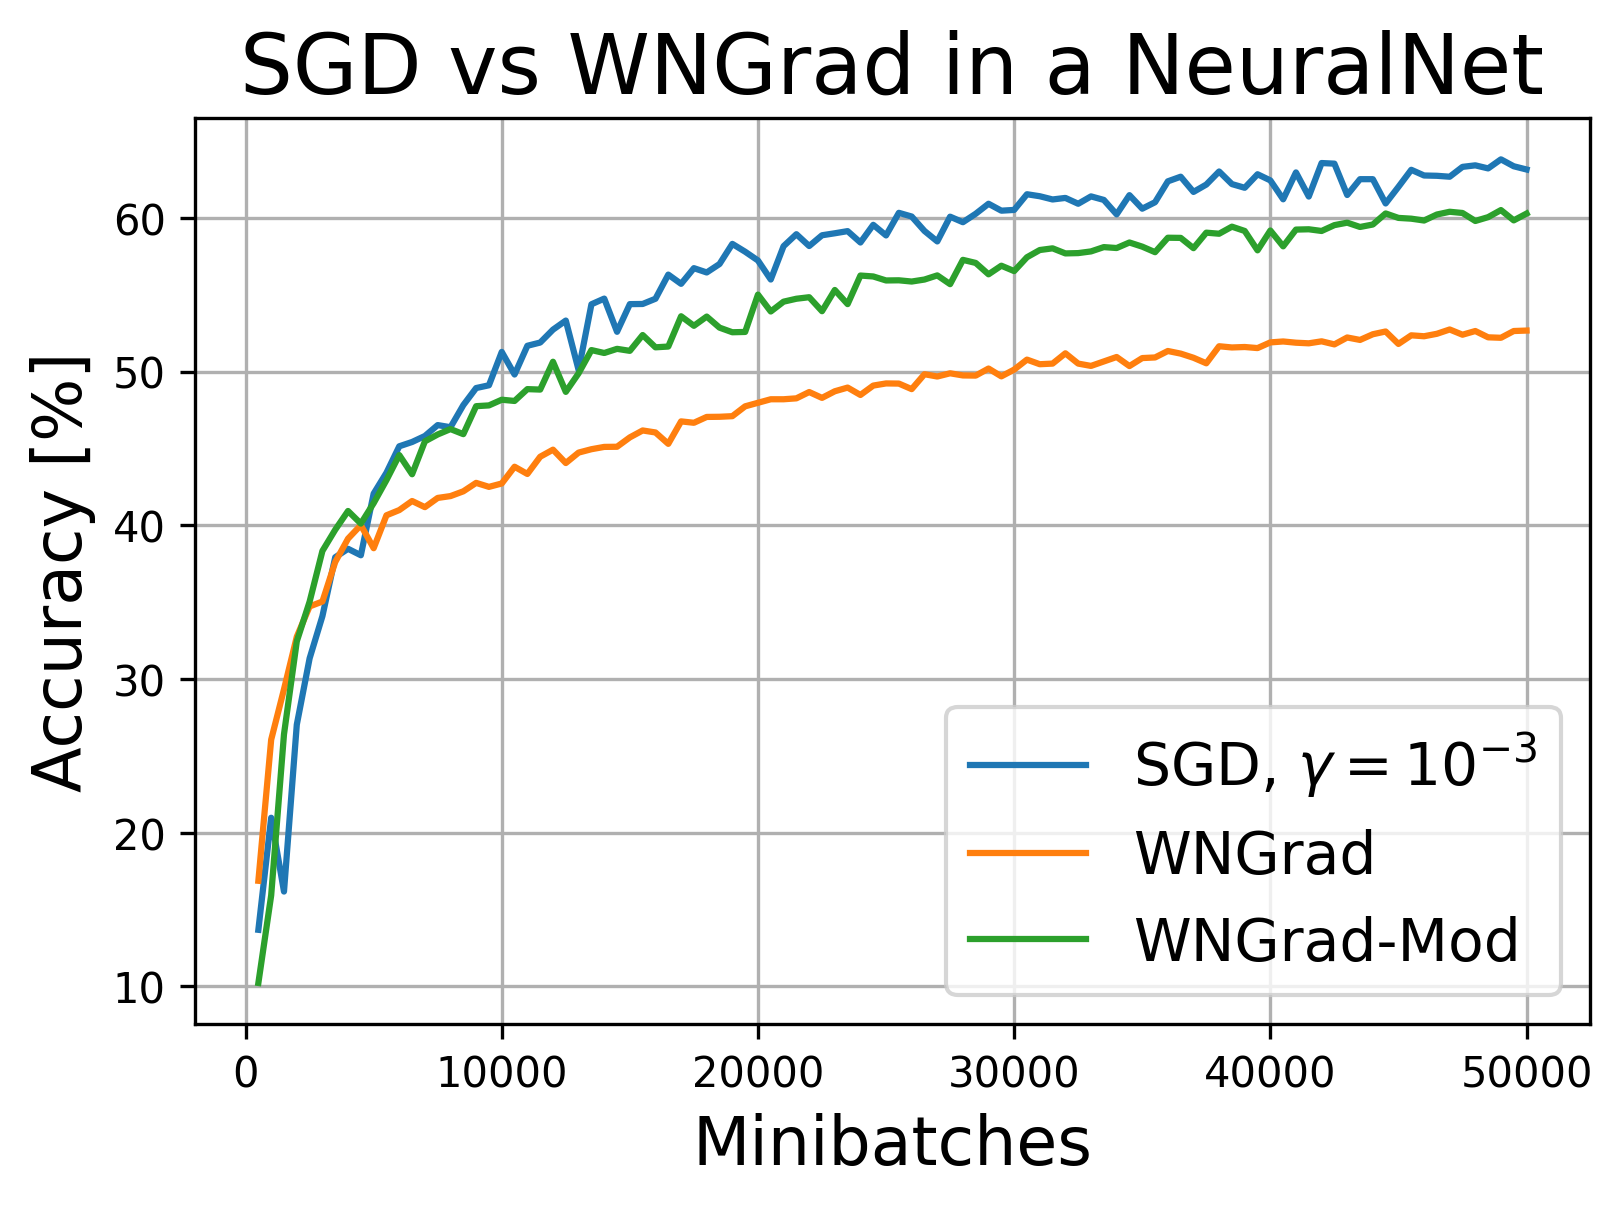

In [19]:
plt.figure()
ax = plt.gca(); ax.grid(); fig = plt.gcf()
# SGD
plt.plot(history["iter"], history["test accuracy"], label="SGD, $\gamma = 10^{-3}$")
# WNGRAD w bsq
plt.plot(history_WNGrad_bsq["iter"], history_WNGrad_bsq["test accuracy"], label="WNGrad")
# WN Grad mod
plt.plot(history_WNGrad["iter"], history_WNGrad["test accuracy"], label="WNGrad-Mod")
plt.xlabel('Minibatches', fontsize=16); plt.ylabel('Accuracy [%]', fontsize = 16)
plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14}); plt.title('SGD vs WNGrad in a NeuralNet', fontsize = 20)
plt.show()

In [22]:
fig.savefig('CIFAR10.png')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002927FDC83A8>
Traceback (most recent call last):
  File "c:\users\dolly\documents\epfl\ma-3\deeplearning\env_deepl\lib\site-packages\torch\utils\data\dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "c:\users\dolly\documents\epfl\ma-3\deeplearning\env_deepl\lib\site-packages\torch\utils\data\dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
